### A demo for the gen_data_2D function
#### This time we add time!

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, colorbar

I added some self-generated pattern images in the data folder. <br>
However, I understand that doing deep learning may need a relatively large training set, so I suggest you to use random generated images to train and maybe use these pattern images for fun.<br>
Also, you could easily generate similar pattern images use any painting tools on your computer, just set the background to be dark and draw whatever you want and save it and you are all set. :D <br>

### Here goes the demo!
(The generate function is defined at the very end of this and you could also find it outside as a py file.)

First pattern image


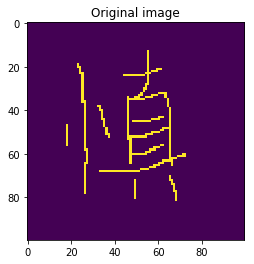

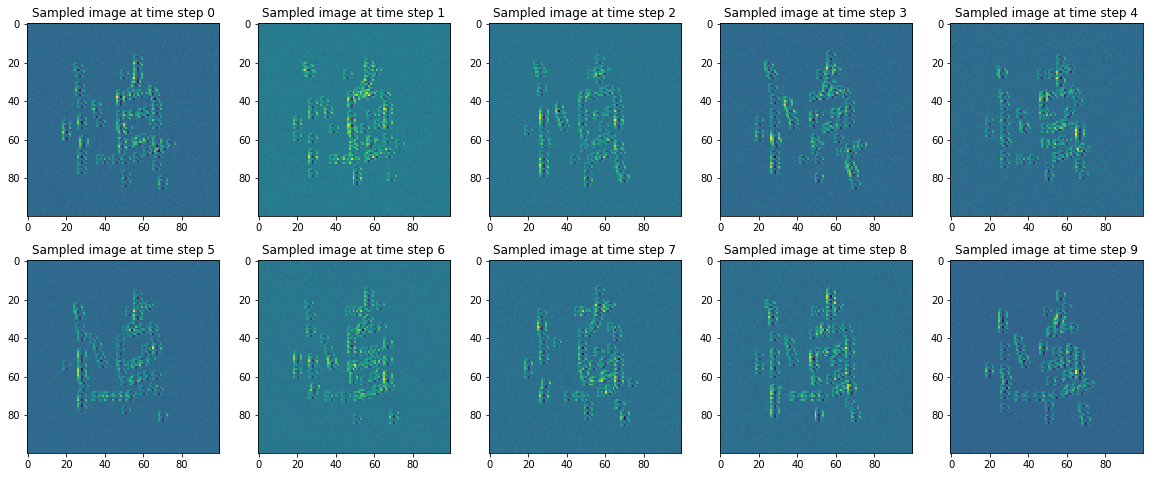

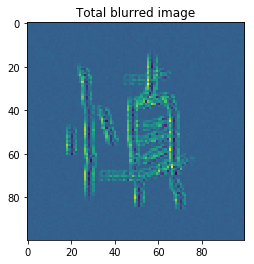

Second pattern image


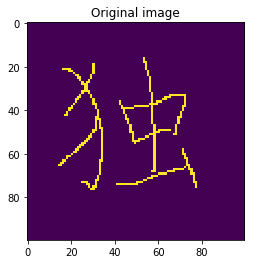

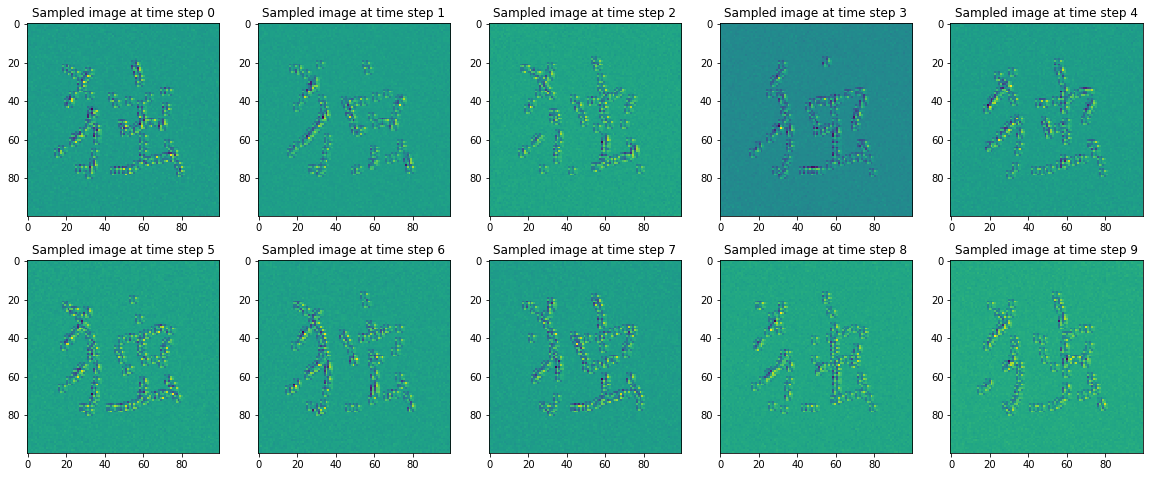

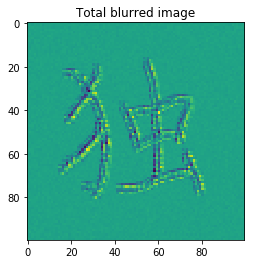

Random generated image


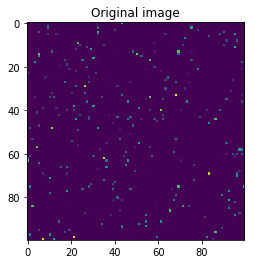

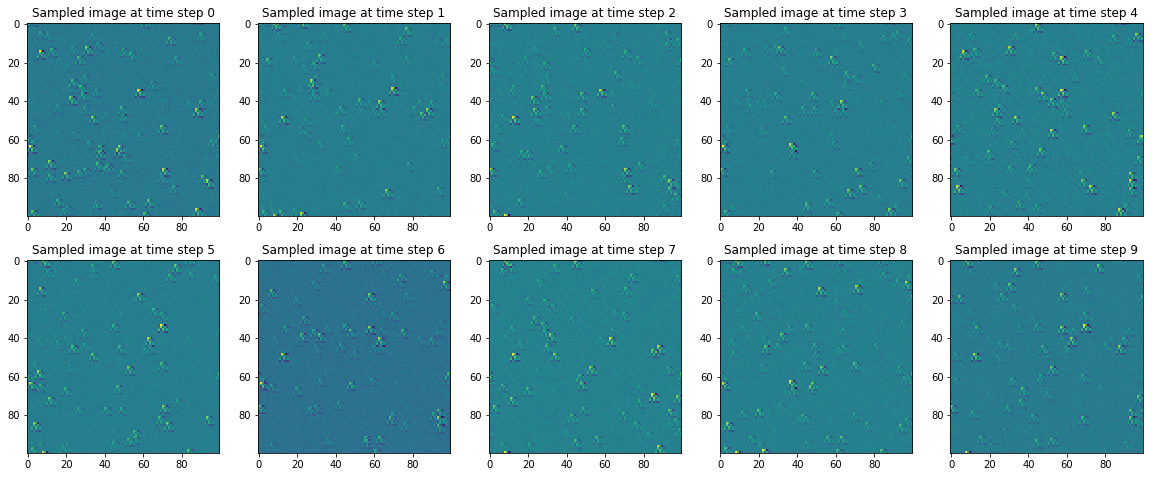

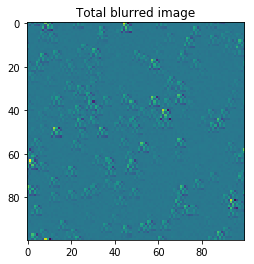

In [254]:
data_dir = os.getcwd() + "/Data/" # You may need to change this path
X_0 = plt.imread(data_dir + "shen.png")[:,:,0]
arg = {"n": 5,
       "b": 0.3,
       "T": 10,
       "noise_level": 0.1,
       "a_type": "randn",
       "raw_data_handeling": "max_0",
       "X_0": X_0}
[X_0, X_with_time, y_with_time, y_total] = gen_data_2D_with_time(arg, pattern = True)
print("First pattern image")
plotting_results(X_0, y_with_time)

print("Second pattern image")
X_1 = plt.imread(data_dir + "du.png")[:,:,0]
arg["X_0"] = X_1
[X_0, X_with_time, y_with_time, y_total] = gen_data_2D_with_time(arg, pattern = True)
plotting_results(X_0, y_with_time, x_with_time = 0, plot_x = False)

print("Random generated image")
arg["theta"] = 0.05
arg["xgrid"] = [100, 100]
arg["x_type"] = 'bernoulli-gaussian'
[X_0, X_with_time, y_with_time, y_total] = gen_data_2D_with_time(arg, pattern = False)
plotting_results(X_0, y_with_time, x_with_time = 0, plot_x = False)

In [3]:
# I choose T = 10 throughout this demo
def plotting_results(x_original, y_with_time, x_with_time = 0, plot_x = False):
    # Plot original signal
    fig = plt.figure(figsize = (4, 4))
    plt.imshow(x_original)
    plt.title("Original image")
    plt.show()
    
    m_0, m_1, T = y_with_time.shape
    weight = 1 / T
    y_to_show = np.zeros([m_0,m_1])
    # Plot images we could see at each time step
    fig1 = plt.figure(figsize = (20, 8))
    for t in range(T):
        plt.subplot(2, 5, t + 1)
        plt.imshow(y_with_time[:,:,t])
        plt.title(f"Sampled image at time step {t}")
        y_to_show += weight * y_with_time[:,:,t]
    plt.show()
        
    
    if plot_x:
        fig2 = plt.figure(figsize = (4, 20))
        for t in range(T):
            plt.subplot(2, 5, t + 1)
            plt.imshow(x_with_time[:,:,t])
            plt.title(f"Original image at time step {t}")
            plt.show()
    
    # Plot the total blurred image
    fig3 = plt.figure(figsize = (4, 4))
    plt.imshow(y_to_show)
    plt.title("Total blurred image")
    plt.show()

#### Below is the actual generating function.

In [13]:
# generate the groudtruth data
# y = sum_{k=1}^K a0k conv x0k + b*1 + n
def gen_data_2D_with_time(arg, pattern = False):
    """
    Parameters:
    ----------------
    arg should include the following items {
        theta: the threshold for generating spike train X_0
        x_grid: a length 2 list denoting the grid dimension for X
        n: the dimension of the kernel (we use squared kernel)
        b: the magnitude of the bias term
        T: how many time steps do you want
        noise_level: the magnitude of noise
        a_type: the kernel type we want to apply on X (randn, 2d-gaussian, sinc)
        x_type: which method we want to generate x_0 (bernoulli, bernoulli-gaussian)
        raw_data_handeling: our generated X may have some entry as negative values,
                        however, this will not happen in real image, so we need
                        to take care of those negative entries. (max_0, sigmoid)
        X_0: pattern image
        }
    
    pattern: whether you want to use a pattern image or not, default is no,
             means we want to generate some random image
    """
    # Take the inputs!
    n = arg["n"] # Dimension of the kernel
    b = arg["b"] # Magnitude of the bias term
    T = arg["T"] # How many time steps to take
    noise_level = arg["noise_level"] # the magnitude of noise
    a_type = arg["a_type"] # Kernel type
    raw_data_handeling = arg["raw_data_handeling"]
    
    if pattern:
        X_0 = arg["X_0"]
    else:
        theta = arg["theta"]
        x_grid = arg["xgrid"]
        x_type = arg["x_type"]
    
    # generate the kernel a_0
    case = a_type.lower()
    if case == "randn": # Random Gaussian
        a_0 = np.random.normal(size = [n, n])
    elif case == "sinc":
        sigma = 0.05
        a_0 = np.sinc((t-0.5)/sigma)
    elif case == "2d-gaussian":
        sigma = 0.5 # could perturb sigma if you want
        # 2D gaussian kernel
        grid_hori = np.linspace(-n / 2, n / 2, n)
        grid_verti = grid_hori.copy()
        mesh_x, mesh_y = np.meshgrid(grid_hori, grid_verti)
        a_0 = 1 / np.sqrt(2 * np.pi * sigma ** 2) * np.exp(-(mesh_x ** 2 + mesh_y ** 2) / 2 * sigma ** 2)
    else:
        raise ValueError("Wrong type")

    #a_0 = a_0 / np.linalg.norm(a_0, axis = 0)  # Normalize kernel by column
    a_0 = a_0 / np.max(np.linalg.eig(a_0)[0])
    
    if pattern == False:
        #### Change: For the purpose of avoiding possible index reflection caused by circular convolution
        # we first generate X on a relatively small image compared to the actual image size we want,
        # and then zero pad it to the actual image
        # Generate the spike train x_0
        m_0_true, m_1_true = x_grid
        m_0 = m_0_true - 2 * n
        m_1 = m_1_true - 2 * n
        
        case_x = x_type.lower()
        if case_x == "bernoulli":
            X_0 = (np.random.uniform(size = [m_0, m_1]) <= theta).astype(int) # Bernoulli spike train
        elif case_x == 'bernoulli-gaussian':
            # Gaussian-Bernoulli spike train
            X_0 = np.random.normal(size = [m_0, m_1]) * (np.random.uniform(size = [m_0, m_1]) <= theta)
        else:
            raise ValueError("Wrong type")
        # Now handle negative entries
        if case_x != "bernoulli":
            case_handle = raw_data_handeling.lower()
            if case_handle == "max_0":
                X_0 = np.maximum(X_0, 0)
            elif case_handle == "sigmoid":
                indices = (X_0 < 0)
                X_0[indices] = 1 / (1 + np.exp(-X_0[indices]))
                
        # Now zero pad x to the actual image size we want
        X_0 = np.pad(X_0, (n, n), "constant", constant_values= 0)
                
    else:# If we want to use some image with some patterns on it
        m_0, m_1 = X_0.shape
    
    # Now we have X_0 either from random sampling or from pattern image, we 
    # sample the time steps
    indexes = np.where(X_0 != 0) # Nonzero X_0 entries
    # Since our aim should be that by passing through all the time steps,
    # All point should have the chance to reveal itself, so we need to choose 
    # a suitable z (number of shining points at a time step),
    # I see this as a complexed version of the Coupon collecting problem, although not the same
    # we could use the solution to that problem as a guideline.
    X_with_time = np.zeros([m_0_true, m_1_true, T]) # Samples we take at each time step
    y_with_time = np.zeros([m_0_true, m_1_true, T]) # The blurred y we want to return, where y[:,:,t] means
                                          # y at time step t
    # We first calculate a lower bound for z using the idea of Coupon collecting problem
    def solving_ccp(total_entries, T): # Giving a lower bound of z
        # total entries denote number of non-zero entries in the input
        z = 1 # initialize z
        gamma = 0.577216 # Euler–Mascheroni constant
        ratio = total_entries // z
        while ratio * np.log(ratio) + gamma * ratio + 0.5 > T:
            z += 1
            ratio = total_entries // z
        
        return z
    
    total_entries = np.sum(X_0 != 0)
    # This lower bound is just for this test case, could set it lower if we want more challenge
    z_lower_bound = solving_ccp(total_entries, T)
    # Now in every time step, we pick a z value between lower bound of z and some multiplication of z
    multi_factor = 1.2 # Could change if you want
    z_upperbound = int(z_lower_bound * multi_factor)
    
    for t in range(T):
        z = np.random.randint(z_lower_bound, z_upperbound + 1)
        # Take random samples from indexes
        random_samples = np.random.randint(0, total_entries, z)
        index_to_take = [indexes[i][random_samples] for i in range(len(indexes))]
        current_X = np.zeros([m_0_true, m_1_true])
        current_X[tuple(index_to_take)] = X_0[tuple(index_to_take)]
        X_with_time[:,:,t] = current_X

        # generate the data y = a_0 conv b_0 + bias + noise
        ##### Circular convolution alert
        y_0 = cconv(a_0, current_X, [m_0_true, m_1_true]) + b * np.ones([m_0_true, m_1_true])
        current_y = y_0 + np.random.normal(size = [m_0_true, m_1_true]) * noise_level
        y_with_time[:,:,t] = current_y
    
    # We also return a blurred image of X_0 without sampling
    y_total = cconv(a_0, X_0, [m_0_true, m_1_true]) + b * np.ones([m_0_true, m_1_true])
    y_total = y_total + np.random.normal(size = [m_0_true, m_1_true]) * noise_level
        
    return [X_0, X_with_time, y_with_time, y_total]


def cconv(mat1, mat2, output_shape):
    # Since there's a lot of functions use circular function
    # and python doesn't have a function for that
    # Dependency of gen_data
    
    return np.real((np.fft.ifft2(np.fft.fft2(mat1, s = output_shape) \
                        * np.fft.fft2(mat2, s = output_shape))))

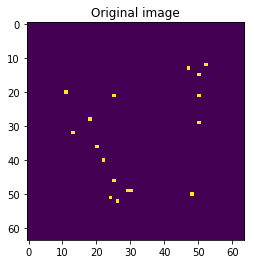

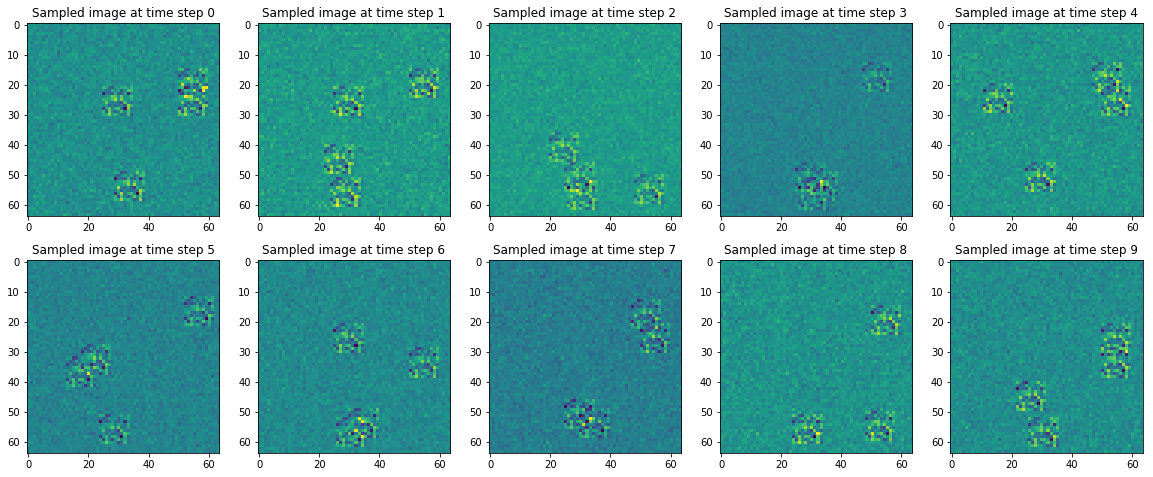

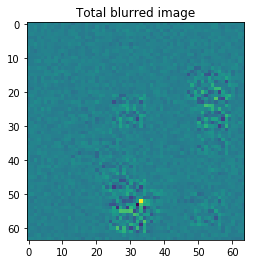

In [17]:
# After fix, now even if kernel size is very large compared to 
# image size, we don't see any index reflection on the other side
arg = {"n": 10,
       "b": 0.3,
       "T": 10,
       "noise_level": 0.1,
       "a_type": "randn",
       "raw_data_handeling": "max_0",
       "theta": 0.01,
       "xgrid": [64,64],
       "x_type": "bernoulli"}

[X_0, X_with_time, y_with_time, y_total] = gen_data_2D_with_time(arg, pattern = False)
plotting_results(X_0, y_with_time, x_with_time = 0, plot_x = False)